# StyleGAN

This notebook is for implementing __A Style-Based Generator Architecture for Generative Adversarial Networks__ from the [paper](https://arxiv.org/abs/1812.04948) with [Tensorflow](https://www.tensorflow.org/).  
Datasets are 1024x1024 [celebA-HQ](https://drive.google.com/drive/folders/11Vz0fqHS2rXDb5pprgTjpD7S2BAJhi1P).

Reference: [tkarras's github](https://github.com/tkarras/progressive_growing_of_gans)(official implementation with tensorflow)

## IMPORT MODULE

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import datetime
from sklearn.utils import shuffle
import time

Instructions for updating:
non-resource variables are not supported in the long term


## DEFINE PARAMETER

In [3]:
algorithm = 'StyleGAN'

feature_size = 3
img_size = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
gen_fmaps_size = [512, 512, 512, 512, 256, 128, 64, 32, 16]
dis_fmaps_size = [512, 512, 512, 512, 512, 256, 128, 64, 32, 16, 16]
batch_size = [16, 16, 16, 16, 16, 16, 14, 6, 3]
minibatch_size = [16, 16, 16, 16, 16, 16, 14, 6 ,3]

num_epoch = [27, 54, 54, 54, 54, 54, 54, 54, 54]
num_stage = 9
start_stage = 0
n_latent = 512

beta1 = 0
beta2 = 0.99
ep = 1e-8

learning_rate = 0.001

train_model = True
load_model = False

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")
save_path = './saved_models/' + date_time + "_" + algorithm + "/save"
load_path = './saved_models/20200511-13-46-12_StyleGAN/save'

# WGAN_GP Parateter
D_lambda = 10

## IMPORT DATASET

In [4]:
def img_norm(img):
    return (img - (255/2)) / (255/2)

def denorm(img):
    out = (img + 1) / 2
    return np.clip(out, 0, 1)

In [5]:
def load_img(nums, stage):
    out = []
    if stage <= 5:
        dataset = str(128)
    else:
        dataset = str(2 ** (stage + 2))
    for num in nums:
        temp = glob.glob('./datasets/celebaHQ/data'+dataset+'x'+dataset +'/'+str(num).zfill(5)+'.jpg')
        out.append(img_norm(cv2.cvtColor(cv2.imread(temp[0]), cv2.COLOR_BGR2RGB)))      
    return out

## UTILITY

In [6]:
# Utility for batch size image
def batch_resize(img, img_size):
    out = []
    for i in range(len(img)):
        out.append(cv2.resize(img[i], (img_size, img_size)))
    return out

def random_latent(batch_size):
    return np.clip(np.random.normal(0,1,[batch_size,n_latent]),-1,1)

## NETWORK

In [7]:
class PGGAN():
    def __init__(self, stage):
        s = stage
        self.alpha = tf.placeholder(shape=[], dtype=tf.float32, name="alpha_stage{}".format(s))
        self.latent_c = tf.placeholder(shape=[None, n_latent], dtype=tf.float32, name="latent_c_stage{}".format(s))
        self.latent_m = tf.placeholder(shape=[None, n_latent], dtype=tf.float32, name="latent_m_stage{}".format(s))
        self.latent_f = tf.placeholder(shape=[None, n_latent], dtype=tf.float32, name="latent_f_stage{}".format(s))
        self.img = tf.placeholder(shape=[None, img_size[s], img_size[s], feature_size], dtype=tf.float32, name="img_stage{}".format(s))
        
        self.fake = self.generator(self.latent_c, self.latent_m, self.latent_f, gen_fmaps_size, s)
        
        self.d_real = self.discriminator(self.img, dis_fmaps_size, s)
        self.d_fake = self.discriminator(self.fake, dis_fmaps_size, s)
        
        self.var = [var for var in tf.trainable_variables() if "stage{}".format(s) in var.name]
        self.var_gen = [var for var in self.var if "generator" in var.name]
        self.var_dis = [var for var in self.var if "discriminator" in var.name]
        
        self.loss_g = self.loss_gen(self.d_fake)
        self.loss_d = self.loss_dis(self.img, self.fake, self.d_real, self.d_fake, s)
        
        opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1, beta2=beta2)
        
        self.opt_gen = opt.minimize(self.loss_g, var_list=self.var_gen)
        self.opt_dis = opt.minimize(self.loss_d, var_list=self.var_dis)
        
    def get_weight(self, shape):
        # not just initializing weights but changing weights dynamically
        fan_in = np.prod(shape[:-1])
        w_scale = np.sqrt(2 / fan_in) # He initializer constant
        w = w_scale * tf.get_variable('weight', shape=shape, initializer=tf.initializers.random_normal())
        return w
    
    def apply_bias_expand(self, x):
        b = tf.get_variable('bias', shape=[x.shape[-1]], initializer=tf.initializers.zeros())
        return x + tf.reshape(b, [1,1,1,-1])

    def apply_bias(self, x):
        b = tf.get_variable('bias', shape=[x.shape[-1]], initializer=tf.initializers.zeros())
        return x + b
    
    def dense_expand(self, x, fmaps):
        w = self.get_weight([x.shape[1].value, fmaps])
        x = tf.matmul(x, w)
        return self.apply_bias_expand(x)

    def dense(self, x, fmaps):
        w = self.get_weight([x.shape[1].value, fmaps])
        x = tf.matmul(x, w)
        return self.apply_bias(x)
    
    def conv2d(self, x, fmaps, kernel, padding):
        w = self.get_weight([kernel, kernel, x.shape[-1].value, fmaps])
        x = tf.nn.conv2d(x, w, strides=[1,1,1,1], padding=padding)
        return x
    
    def pixel_norm(self, x, epsilon=1e-8):
        # noramlzing weights with axis of feature
        return x / tf.sqrt(tf.reduce_mean(tf.square(x), axis=-1, keepdims=True) + epsilon)
    
    def minibatch(self, x, stage):
        group_size = minibatch_size[stage]
        s = x.shape
        y = tf.reshape(x, [group_size, -1, s[1], s[2], s[3]])
        mean = tf.reduce_mean(y, axis=0, keepdims=True) # mean value of minibatch
        var = tf.reduce_mean(tf.square(y - mean), axis=0) # variance value of minibatch
        std = tf.sqrt(var + 1e-8) # stddev value of minibatch
        y = tf.reduce_mean(std, axis=[1,2,3], keepdims=True) 
        y = tf.tile(y, [group_size, s[1], s[2], 1]) # duplicate value to input size
        return tf.concat([x,y], axis=-1)
    
    def gen_block(self, x, style, fmaps, scale):
        s = scale
        with tf.variable_scope("scale{}".format(s)):
            with tf.variable_scope("conv1"):
                x = self.conv2d(x, fmaps[s], 3, "SAME")
                x = self.apply_noise(x)
                x = self.apply_bias_expand(x)
                x = tf.nn.leaky_relu(x)
                x = self.AdaIN(x, style, fmaps[s])
            with tf.variable_scope("conv2"):
                x = self.conv2d(x, fmaps[s], 3, "SAME")
                x = self.apply_noise(x)
                x = self.apply_bias_expand(x)
                x = tf.nn.leaky_relu(x)
                x = self.AdaIN(x, style, fmaps[s])
        return x
                
    def dis_block(self, x, fmaps, scale):
        s = scale
        with tf.variable_scope("scale{}".format(s)):
            with tf.variable_scope("conv1"):
                x = self.conv2d(x, fmaps[s+1], 3, "SAME")
                x = self.apply_bias_expand(x)
                x = tf.nn.leaky_relu(x)
            with tf.variable_scope("conv2"):
                x = self.conv2d(x, fmaps[s], 3, "SAME")
                x = self.apply_bias_expand(x)
                x = tf.nn.leaky_relu(x)
        return x
    
    def upscale(self, x):
        size = int(x.shape[1].value * 2)
        return tf.image.resize_bilinear(x, [size,size])
    
    def downscale(self, x):
        return tf.nn.avg_pool2d(x, ksize=2, strides=2, padding="VALID")
    
    def toRGB(self, x, scale, direct):
        s = scale
        # direct 1 is connected with current scale layer and 2 is connected with previous scale layer
        with tf.variable_scope("scale{}".format(s)):
            with tf.variable_scope("toRGB_{}".format(direct)):
                x = self.conv2d(x, feature_size, 1, "SAME")
                x = self.apply_bias_expand(x)
        return x
        
    def fromRGB(self, x, fmaps, scale, direct):
        s = scale
        # direct 1 is connected with current scale layer and 2 is connected with previous scale layer
        with tf.variable_scope("scale{}".format(s)):
            with tf.variable_scope("fromRGB_{}".format(direct)):
                if direct == 1: 
                    x = self.conv2d(x, fmaps[s+1], 1, "SAME")
                    x = self.apply_bias_expand(x)
                else: 
                    x = self.conv2d(x, fmaps[s], 1, "SAME")
                    x = self.apply_bias_expand(x)
        return tf.nn.leaky_relu(x)
    
    def generator(self, z_c, z_m, z_f, fmaps, stage):
        with tf.variable_scope("generator_stage{}".format(stage), reuse=tf.AUTO_REUSE):
            course_style = self.mapping_network(z_c)
            middle_style = self.mapping_network(z_m)
            fine_style   = self.mapping_network(z_f)
            
            with tf.variable_scope("scale0"):
                with tf.variable_scope("conv1"):
                    x = tf.get_variable('const', shape=[1, 4, 4, fmaps[0]], initializer=tf.initializers.ones())
                    x = self.conv2d(x, fmaps[0], 3, "SAME")
                    x = self.apply_noise(x)
                    x = self.apply_bias_expand(x)
                    x = tf.nn.leaky_relu(x)
                    x = self.AdaIN(x, course_style, fmaps[0])
            if stage == 0:
                x = self.toRGB(x, 0, 1)

            # s th scale layers
            for s in range(stage):
                if s < 2:
                    style = course_style 
                elif s < 4:
                    style = middle_style 
                else:
                    style = fine_style
                    
                shortcut = x
                up1 = self.upscale(x)
                x = self.gen_block(up1, style, fmaps, s+1)
                if s == stage-1:
                    rgb1 = self.toRGB(x, s+1, 1)
                    rgb2 = self.toRGB(shortcut, s+1, 2)
                    up2 = self.upscale(rgb2)
                    x = self.alpha*rgb1 + (1-self.alpha)*up2
                    
            return tf.nn.tanh(x)
    
    def discriminator(self, x, fmaps, stage):
        with tf.variable_scope("discriminator_stage{}".format(stage), reuse=tf.AUTO_REUSE):
            rgb1 = self.fromRGB(x, fmaps, stage, 1)
            if stage == 0:
                x = rgb1
            for s in range(stage):
                if s == 0: # the last scale of stage
                    down2 = self.downscale(x)
                    rgb2 = self.fromRGB(down2, fmaps, stage, 2)
                    x = self.dis_block(rgb1, fmaps, stage)
                    down1 = self.downscale(x)
                    x = self.alpha*down1 + (1-self.alpha)*rgb2
                else:
                    x = self.dis_block(x, fmaps, stage-s)
                    up1 = self.downscale(x)
                    x = up1
            
            mini = self.minibatch(x, stage)
    
            with tf.variable_scope("scale0"):
                with tf.variable_scope("conv1"):
                    x = self.conv2d(mini, fmaps[1], 3, "SAME")
                    x = self.apply_bias_expand(x)
                    x = tf.nn.leaky_relu(x)
                with tf.variable_scope("conv2"):
                    x = self.conv2d(x, fmaps[0], 4, "VALID")
                    x = self.apply_bias_expand(x)
                    x = tf.nn.leaky_relu(x)
            
                flat = tf.layers.flatten(x)
                with tf.variable_scope("dense1"):
                    out = self.dense_expand(flat, 1)
                    
        return out
    
    # Use WGAN-GP Loss
    def loss_gen(self, d_fake):
        return -tf.reduce_mean(d_fake)
    
    def loss_dis(self, real, fake, d_real, d_fake, stage):
        loss = tf.reduce_mean(d_fake) - tf.reduce_mean(d_real)
        
        alpha = tf.random_uniform([tf.shape(real)[0],1,1,1], 0, 1)
        mix = alpha*real + (1-alpha)*fake
        d_mix = self.discriminator(mix, dis_fmaps_size, stage)
        loss_mix = tf.reduce_sum(d_mix)
        grad = tf.gradients(loss_mix, [mix])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1,2,3]))
        GP = tf.square(norm - 1)
        loss += D_lambda*tf.reduce_mean(GP)
        
        loss += 1e-3*tf.reduce_mean(tf.square(d_real)) # preventing dis_loss from diverging
        return loss
    
    def mapping_network(self, z):
        # Normalize, 8 dense 
        z = self.pixel_norm(z)
        with tf.variable_scope('MappingNetwork', reuse=tf.AUTO_REUSE):
            for i in range(8):
                with tf.variable_scope('Mapping_fc'+str(i), reuse=tf.AUTO_REUSE):
                    out = tf.nn.leaky_relu(self.dense(z, n_latent))
                    z = out
            return out 
    
    # Reference: https://github.com/NVlabs/stylegan
    def apply_noise(self, x):
        with tf.variable_scope('Noise'):
            noise = tf.random_normal([tf.shape(x)[0], x.shape[1], x.shape[2], 1], dtype=x.dtype)
            weight = tf.get_variable('weight', shape=[x.shape[-1].value], initializer=tf.initializers.zeros())
            return x + noise * tf.reshape(tf.cast(weight, x.dtype), [1, 1, 1, -1])

    def AdaIN(self, x, y, n_fmap):
        mean, var = tf.nn.moments(x, axes=[1, 2], keep_dims=True)

        w = self.MLP(y, n_fmap)

        y_s = tf.slice(w, [0, 0], [-1, n_fmap])
        y_b = tf.slice(w, [0, n_fmap], [-1, n_fmap])

        y_s = tf.expand_dims(tf.expand_dims(y_s, 1), 1)
        y_b = tf.expand_dims(tf.expand_dims(y_b, 1), 1)   
        
        out = y_s * ((x - mean) / var) + y_b 
        
        return out 

    def MLP(self, x, n_fmap):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            with tf.variable_scope('fc1', reuse=tf.AUTO_REUSE):
                fc1 = tf.nn.leaky_relu(self.dense(x, n_fmap))
            with tf.variable_scope('fc2', reuse=tf.AUTO_REUSE):
                fc2 = self.dense(fc1, 2*n_fmap)

        return fc2
        

## INITIALIZATION

In [8]:
# Initialize variables
net = [PGGAN(s) for s in range(num_stage)] # train stage step by step, 0 to 8
init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
sess.run(init)

Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.


## LOAD MODEL

In [10]:
Load_Saver = [tf.train.Saver(var_list=net[s].var) for s in range(num_stage)]
Saver = tf.train.Saver()

if load_model == True:
    for s in range(1,start_stage):
        Load_Saver[s].restore(sess, load_path+str(s))

INFO:tensorflow:Restoring parameters from ./saved_models/20200511-13-46-12_StyleGAN/save7


## TRAIN

In [11]:
start_time = time.time()
if train_model:
    fixed_latent1 = random_latent(36)
    fixed_latent2 = random_latent(36)
    len_data = 30000
    for s in range(start_stage, num_stage):
        alpha = 0
        train_set = np.array(range(30000)) + 1
        total_batchs = len_data // batch_size[s]
        
        if s != 0:
            for var in net[s].var_gen:
                var_gen = var.name.split('/')
                for var_old in net[s-1].var_gen:
                    var_gen_old = var_old.name.split('/')
                    
                    var_name_check_list = []
                    if len(var_gen) == len(var_gen_old):
                        for check_idx in range(1,len(var_gen)):
                            var_name_check_list.append(var_gen[check_idx] == var_gen_old[check_idx])
                
                    if len(var_name_check_list) != 0 and all(var_name_check_list):
                        print(var_gen)
                        print(var_gen_old)
                        sess.run(var.assign(var_old))
                    if ("RGB_2" in var_gen[2]) and ("RGB_1" in var_gen_old[2]) and (var_gen[3] == var_gen_old[3]):
                        print(var_gen)
                        print(var_gen_old)
                        sess.run(var.assign(var_old))
            print("Generator is assigned!")

            for var in net[s].var_dis:
                var_dis = var.name.split('/')
                for var_old in net[s-1].var_dis:
                    var_dis_old = var_old.name.split('/')
                    
                    var_name_check_list = []
                    if len(var_dis) == len(var_dis_old):
                        for check_idx in range(1,len(var_dis)):
                            var_name_check_list.append(var_dis[check_idx] == var_dis_old[check_idx])
                
                    if len(var_name_check_list) != 0 and all(var_name_check_list):
                        print(var_dis)
                        print(var_dis_old)
                        sess.run(var.assign(var_old))
                    if ("RGB_2" in var_dis[2]) and ("RGB_1" in var_dis_old[2]) and (var_dis[3] == var_dis_old[3]):
                        print(var_dis)
                        print(var_dis_old)
                        sess.run(var.assign(var_old))

            print("Discriminator is assigned!")
            print("Assignment is Finished!")
                        
        count_batch = 0
        for epoch in range(num_epoch[s]):
            train_set = shuffle(train_set)

            for batch in range(total_batchs):
                batch_set = train_set[batch * batch_size[s] : (batch + 1) * batch_size[s]]
                batch_img = load_img(batch_set, s)
#               if stage is 4-64, use batch_resize. Because there is no image dataset for these stages.
#               if stage is 128-1024, use original image datasets.
                batch_img = batch_resize(batch_img, img_size[s])
                batch_latent = random_latent(batch_size[s])

                alpha += (1 / (total_batchs*(num_epoch[s]/2)))
                if alpha >= 1: alpha = 1
                
                feed_dict = {net[s].alpha: alpha,
                             net[s].latent_c: batch_latent,
                             net[s].latent_m: batch_latent,
                             net[s].latent_f: batch_latent,
                             net[s].img: batch_img}
                
                _, loss_dis = sess.run([net[s].opt_dis, net[s].loss_d],
                                       feed_dict = feed_dict)
                
                batch_latent = random_latent(batch_size[s])
                feed_dict = {net[s].alpha: alpha,
                             net[s].latent_c: batch_latent,
                             net[s].latent_m: batch_latent,
                             net[s].latent_f: batch_latent}
                
                _, loss_gen = sess.run([net[s].opt_gen, net[s].loss_g],
                                              feed_dict = feed_dict)
                second = time.time() - start_time
                print("Stage: {} / Batch: {} / {} / Alpha: {:.3f} / Time: {} d, {} h, {} m, {:.3f} s".format(\
                    s, count_batch, total_batchs*num_epoch[s], alpha,\
                    int(second // (60*60*24)), int(second // (60*60)) % (24), int(second // 60) % 60, second % 60), end="\r")
                    
                count_batch += 1
                
            fake_test = sess.run(net[s].fake, feed_dict = {net[s].latent_c: fixed_latent1,
                                                           net[s].latent_m: fixed_latent1,
                                                           net[s].latent_f: fixed_latent1,
                                                           net[s].alpha: alpha})
            fig, ax = plt.subplots(6,6, figsize=[10,10])
            for k in range(36):
                ax[k//6,k%6].imshow(denorm(fake_test[k]))
                ax[k//6,k%6].axis("off")
            plt.tight_layout()
            plt.xticks([]), plt.yticks([])
            plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
            fig.savefig("./save_style_progress/" + str(s) + "_" + str(epoch+1).zfill(5) + '.png')
            plt.close(fig)
            
            latent_test1 = random_latent(10)
            latent_test2 = random_latent(10)

            fake_test_1 = sess.run(net[s].fake, feed_dict = {net[s].latent_c: latent_test1,
                                                             net[s].latent_m: latent_test1,
                                                             net[s].latent_f: latent_test1,
                                                             net[s].alpha: alpha})

            fake_test_2 = sess.run(net[s].fake, feed_dict = {net[s].latent_c: latent_test2,
                                                             net[s].latent_m: latent_test2,
                                                             net[s].latent_f: latent_test2,
                                                             net[s].alpha: alpha})

            fake_test_c = sess.run(net[s].fake, feed_dict = {net[s].latent_c: latent_test2,
                                                             net[s].latent_m: latent_test1,
                                                             net[s].latent_f: latent_test1,
                                                             net[s].alpha: alpha})

            fake_test_m = sess.run(net[s].fake, feed_dict = {net[s].latent_c: latent_test1,
                                                             net[s].latent_m: latent_test2,
                                                             net[s].latent_f: latent_test1,
                                                             net[s].alpha: alpha})

            fake_test_f = sess.run(net[s].fake, feed_dict = {net[s].latent_c: latent_test1,
                                                             net[s].latent_m: latent_test1,
                                                             net[s].latent_f: latent_test2,
                                                             net[s].alpha: alpha})

            fig, ax = plt.subplots(10,5, figsize=[12,20])

            for k in range(10):
                ax[k,0].imshow(denorm(fake_test_1[k]))
                ax[k,1].imshow(denorm(fake_test_2[k]))
                ax[k,2].imshow(denorm(fake_test_c[k]))
                ax[k,3].imshow(denorm(fake_test_m[k]))
                ax[k,4].imshow(denorm(fake_test_f[k]))

                for l in range(5):
                    ax[k,l].axis("off")

            plt.tight_layout()
            plt.xticks([]), plt.yticks([])
            plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)

            fig.savefig("./save_style_progress/" + str(s) + "_" + str(epoch+1).zfill(5) + '_style.png')
            plt.close(fig)
        
        Saver.save(sess, save_path+str(s))

## TEST

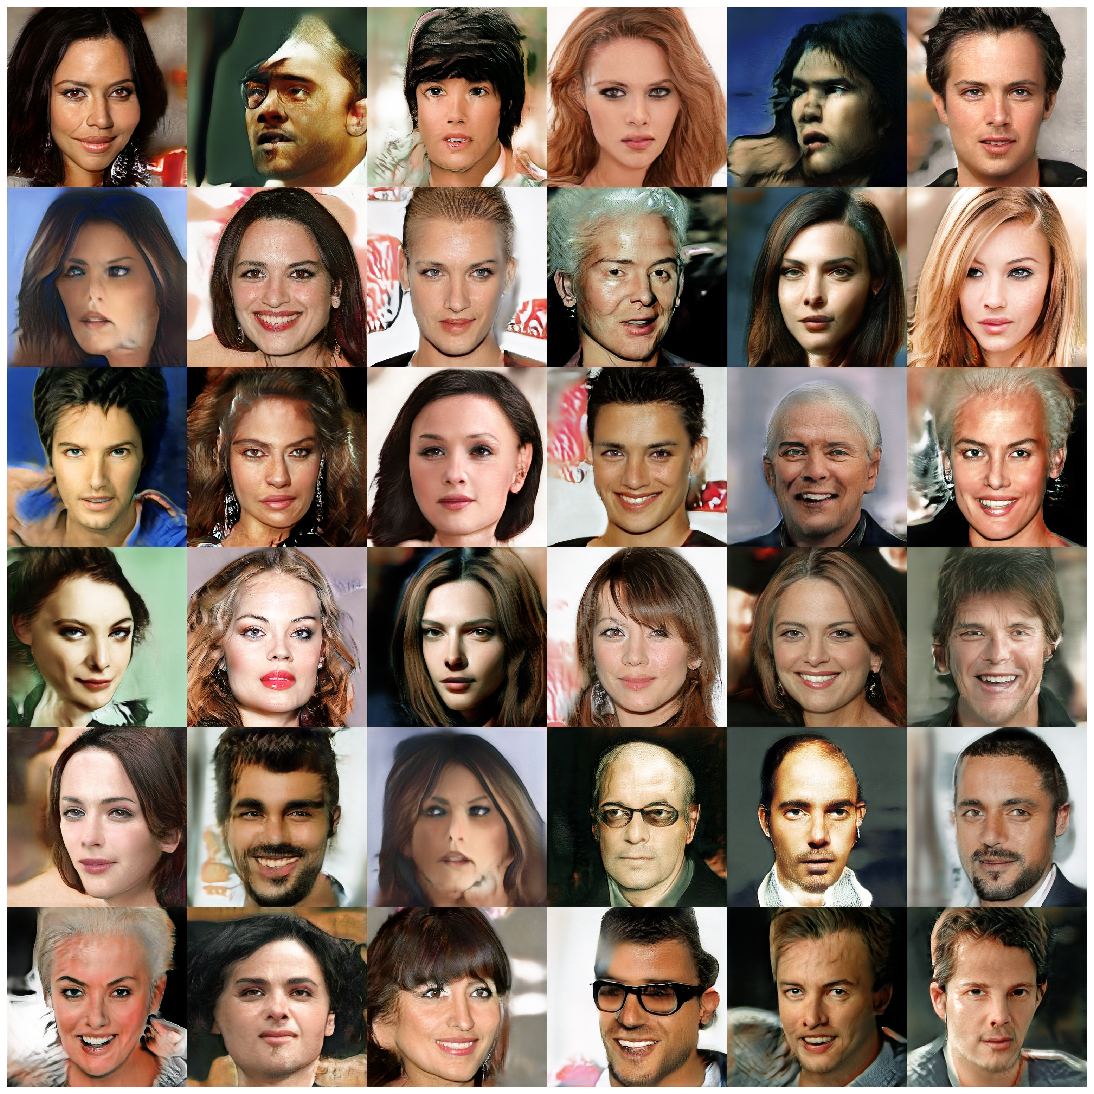

In [233]:
alpha = 1
s = 8
latent_test = random_latent(36)
fake_test = sess.run(net[s].fake, feed_dict = {net[s].latent_c: latent_test,
                                               net[s].latent_m: latent_test,
                                               net[s].latent_f: latent_test,
                                               net[s].alpha: alpha})
fig, ax = plt.subplots(6,6, figsize=[15,15])
for k in range(36):
    ax[k//6,k%6].imshow(denorm(fake_test[k]))
    ax[k//6,k%6].axis("off")
plt.tight_layout()
plt.xticks([]), plt.yticks([])
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
plt.show()

## Test Style

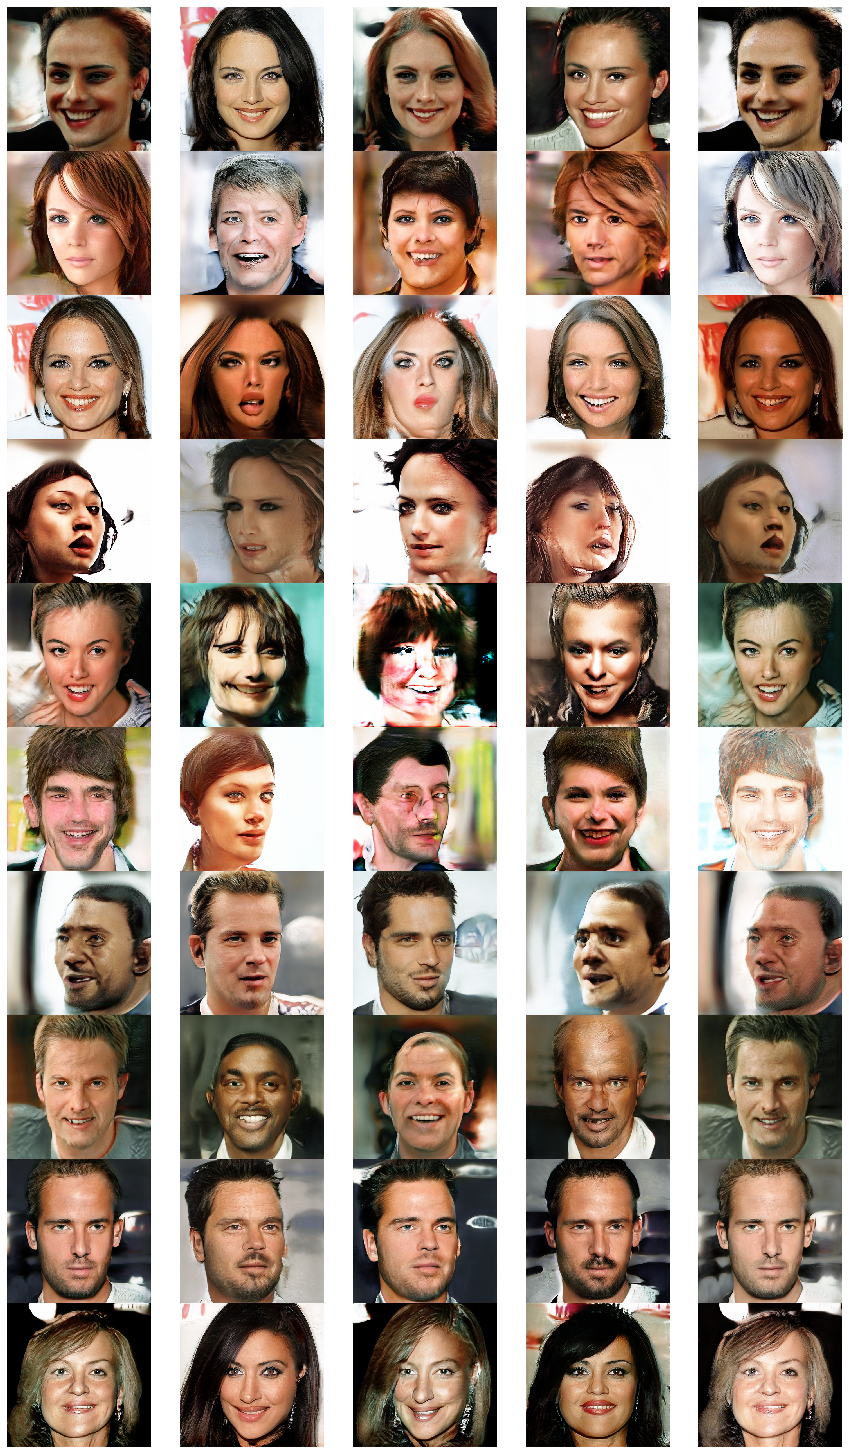

In [89]:
alpha = 1
s = 8

latent_test1 = random_latent(10)
latent_test2 = random_latent(10)

fake_test_1 = sess.run(net[s].fake, feed_dict = {net[s].latent_c: latent_test1,
                                                 net[s].latent_m: latent_test1,
                                                 net[s].latent_f: latent_test1,
                                                 net[s].alpha: alpha})

fake_test_2 = sess.run(net[s].fake, feed_dict = {net[s].latent_c: latent_test2,
                                                 net[s].latent_m: latent_test2,
                                                 net[s].latent_f: latent_test2,
                                                 net[s].alpha: alpha})

fake_test_c = sess.run(net[s].fake, feed_dict = {net[s].latent_c: latent_test2,
                                                 net[s].latent_m: latent_test1,
                                                 net[s].latent_f: latent_test1,
                                                 net[s].alpha: alpha})

fake_test_m = sess.run(net[s].fake, feed_dict = {net[s].latent_c: latent_test1,
                                                 net[s].latent_m: latent_test2,
                                                 net[s].latent_f: latent_test1,
                                                 net[s].alpha: alpha})

fake_test_f = sess.run(net[s].fake, feed_dict = {net[s].latent_c: latent_test1,
                                                 net[s].latent_m: latent_test1,
                                                 net[s].latent_f: latent_test2,
                                                 net[s].alpha: alpha})

fig, ax = plt.subplots(10,5, figsize=[12,20])

for k in range(10):
    ax[k,0].imshow(denorm(fake_test_1[k]))
    ax[k,1].imshow(denorm(fake_test_2[k]))
    ax[k,2].imshow(denorm(fake_test_c[k]))
    ax[k,3].imshow(denorm(fake_test_m[k]))
    ax[k,4].imshow(denorm(fake_test_f[k]))
    
    for l in range(5):
        ax[k,l].axis("off")

plt.tight_layout()
plt.xticks([]), plt.yticks([])
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
plt.show()

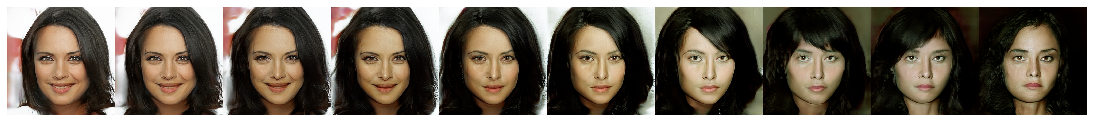

In [115]:
alpha = 1
s = 8
input_a = random_latent(1)[0]
input_b = random_latent(1)[0]
latent_test = np.linspace(input_a, input_b, 10)
fake_test = sess.run(net[s].fake, feed_dict = {net[s].latent_c: latent_test,
                                               net[s].latent_m: latent_test,
                                               net[s].latent_f: latent_test,
                                               net[s].alpha: alpha})

fig, ax = plt.subplots(1,10, figsize=[15,15])
for k in range(10):
    ax[k].imshow(denorm(fake_test[k]))
    ax[k].axis("off")
plt.tight_layout()
plt.xticks([]), plt.yticks([])
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
plt.show()

(-0.5, 511.5, 511.5, -0.5)

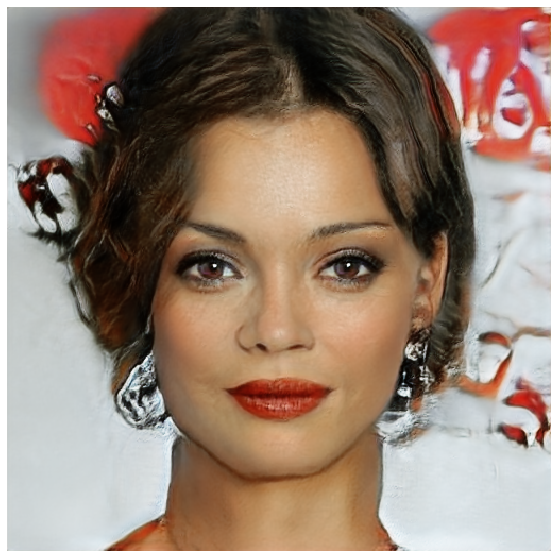

In [659]:
latent = random_latent(1)
fake_test = sess.run(net[s].fake, feed_dict = {net[s].latent_c: latent,
                                               net[s].latent_m: latent,
                                               net[s].latent_f: latent,
                                               net[s].alpha: alpha})

plt.figure(figsize=(10, 10))
plt.imshow(denorm(fake_test[0]))
plt.axis("off")